# Contagem de imagens no dataset

Este script percorre as pastas organizadas por conjunto (`train`, `test`) e classe (`real`, `fake`) dentro do diretório base `data/real-vs-fake`. 

Para cada pasta, conta o número de arquivos `.jpg` presentes e exibe um resumo com a quantidade de imagens reais e falsas em cada conjunto, além do total geral de imagens do dataset.

In [1]:
import os

# Caminho base onde estão armazenadas as imagens organizadas em subpastas
base_path = "data/real-vs-fake"

# Conjuntos de dados
subsets = ["train", "test"]

# Classes presentes no dataset
classes = ["real", "fake"]

# Inicializa um dicionário para contar o número de imagens por classe e por conjunto
total_counts = {
    "train": {"real": 0, "fake": 0},
    "test": {"real": 0, "fake": 0}
}

# Percorre cada combinação de conjunto (train/test) e classe (real/fake)
for subset in subsets:
    for cls in classes:
        path = os.path.join(base_path, subset, cls)  # Caminho completo da pasta
        if os.path.exists(path):
            # Conta apenas arquivos .jpg
            count = len([f for f in os.listdir(path) if f.lower().endswith('.jpg')])
            total_counts[subset][cls] = count
        else:
            print(f" Pasta não encontrada: {path}")

# Exibe os resultados por conjunto
for subset in subsets:
    real = total_counts[subset]["real"]
    fake = total_counts[subset]["fake"]
    total = real + fake
    print(f"\n {subset.upper()}:")
    print(f" - Imagens reais: {real}")
    print(f" - Imagens falsas: {fake}")
    print(f" - Total: {total}")

# Soma total de imagens em todos os conjuntos
total_real = sum(total_counts[s]["real"] for s in subsets)
total_fake = sum(total_counts[s]["fake"] for s in subsets)
print(f"\n Total geral de imagens reais: {total_real}")
print(f" Total geral de imagens falsas: {total_fake}")
print(f" Total geral de imagens: {total_real + total_fake}")



 TRAIN:
 - Imagens reais: 5000
 - Imagens falsas: 5000
 - Total: 10000

 TEST:
 - Imagens reais: 2000
 - Imagens falsas: 2000
 - Total: 4000

 Total geral de imagens reais: 7000
 Total geral de imagens falsas: 7000
 Total geral de imagens: 14000


# Preparação dos dados para treinamento

Este código carrega os datasets de treino e teste usando a classe `RealFakeDataset`, que organiza as imagens e suas respectivas labels.

Em seguida, cria `DataLoader`s para cada dataset com batch size 3. O loader de treino é embaralhado (`shuffle=True`)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from CDCNs import CDCNpp, CDCN, Conv2d_cd
from load_real_fake_dataset import RealFakeDataset
import torch.optim as optim
from tqdm import tqdm

# Carrega os datasets de treino e teste
train_dataset = RealFakeDataset('data/real-vs-fake/train')
test_dataset  = RealFakeDataset('data/real-vs-fake/test')

# Cria os data loaders com batch size 3
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=3, shuffle=False)


In [3]:
# Instanciar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CDCN(basic_conv=Conv2d_cd, theta=0.7)
model = model.to(device)

In [4]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Treinamento do modelo CDCN

Este bloco realiza o treinamento do modelo por 10 épocas. Para cada época:

- O modelo é colocado em modo de treinamento.
- Para cada batch de imagens e labels:
  - As imagens são processadas pelo modelo para gerar um mapa de ativação.
  - O mapa é reduzido para um score médio por imagem.
  - São criados os logits binários para cálculo da perda.
  - Realiza-se o cálculo do gradiente (backpropagation) e atualização dos pesos.
- Ao final de cada época, imprime a perda média do treinamento.

Por fim, os pesos treinados do modelo são salvos em disco.


In [ ]:
import numpy as np

# Número de épocas de treinamento
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Coloca o modelo em modo de treinamento
    total_loss = 0

    # Loop pelos batches de treinamento
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass pelo modelo; map_x é o mapa de ativação de saída
        map_x, *_ = model(images)

        # Calcula a média do mapa para cada imagem (batch_size,)
        outputs = torch.mean(map_x.view(map_x.size(0), -1), dim=1)

        # Cria logits binários: [1 - output, output]
        logits = torch.stack([1 - outputs, outputs], dim=1)

        # Calcula a perda
        loss = criterion(logits, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Mostra o erro médio da época
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

# Salva os pesos do modelo treinado
torch.save(model.state_dict(), "cdcn_real_fake.pth")

# Avaliação do modelo treinado

Este código realiza a avaliação do modelo CDCN no conjunto de teste:

- Carrega o modelo e os pesos treinados, definindo o dispositivo (GPU/CPU).
- Para cada batch do conjunto de teste, realiza o forward pass e calcula uma pontuação média para cada imagem.
- Compara as pontuações com um limiar (0.7) para classificar entre "real" e "fake".
- Acumula as predições e rótulos verdadeiros para análise posterior.
- Calcula e exibe a matriz de confusão e um relatório detalhado com métricas de precisão, recall e F1-score.
- Gera uma visualização da matriz de confusão usando seaborn para melhor interpretação dos resultados.


batch 1334fazendo matriz de confusão
Matriz de Confusão:
[[1344  656]
 [ 103 1897]]

Relatório de Classificação:
              precision    recall  f1-score   support

        Fake       0.93      0.67      0.78      2000
        Real       0.74      0.95      0.83      2000

    accuracy                           0.81      4000
   macro avg       0.84      0.81      0.81      4000
weighted avg       0.84      0.81      0.81      4000



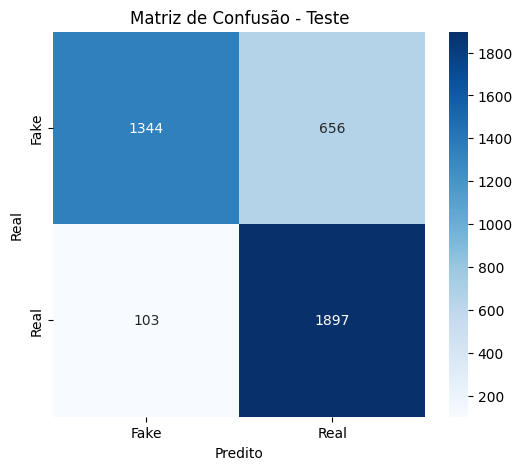

In [5]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

all_preds = []
all_labels = []

# Define o dispositivo: GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instancia o modelo e carrega os pesos treinados
model = CDCN(basic_conv=Conv2d_cd, theta=0.7).to(device)
model.load_state_dict(torch.load("model/cdcn_real_fake.pth", map_location=device))

# Define limiar para classificar como real (> 0.7)
limiar = 0.7
model.eval()  # Coloca o modelo em modo de avaliação

i = 1
with torch.no_grad():
    for images, labels in test_loader:
        print(f'\rbatch {i}', end='', flush=True)
        i += 1

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        map_x, *_ = model(images)

        # Score médio por imagem
        scores = torch.mean(map_x.view(map_x.size(0), -1), dim=1)

        # Converte os scores em classes (0 = fake, 1 = real)
        preds = (scores > limiar).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Avaliação
print("fazendo matriz de confusão")

# Matriz de confusão
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de Confusão:")
print(cm)

# Relatório com precisão, recall, f1-score
print("\nRelatório de Classificação:")
print(classification_report(all_labels, all_preds, target_names=["Fake", "Real"]))

# Visualização da matriz com seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Teste")
plt.show()
